### Creating an image classifier able to find sneakers in instagram posts

The data comprises of few thousand images of sneakers collected using google images and instagram
and few thousand images of sneakers.    
Your goal is to use what you learned from previous examples and create a sneaker-not-sneaker binary classifier.

The task comprises of multiple sub-tasks that you need to do to build the classifier.

1. Create a dataset able to load data from new_meta_sneakers.csv
2. Create a fine tune binary classification architecture.
3. Create a training loop and train your model.

![title](sneakers.png)


### On the bottom of the following cell you see the data you will work with

In [1]:
%matplotlib inline
from torch import nn
import easyimages
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, Sampler
from pretrainedmodels.models import resnet50
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
import torch 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
DATASET_USAGE_PERCENTAGE = 0.1

base_path = os.getcwd() + '/data/fashion_classify_data/'
df = pd.read_csv(os.path.join(base_path,'new_meta_sneakers.csv')).sample(frac=1)
df.image_path = base_path +df.image_path
df.tags = df.tags.map({'sneakers': 1, 'negatives': 0})
df = df.sample(frac=DATASET_USAGE_PERCENTAGE)
df.head()
df.iloc[2]

Unnamed: 0                                                54295
image_path    /Users/falkvandermeirsch/Documents/DSR/4.Deep_...
tags                                                          1
Name: 54295, dtype: object

[51482, '/Users/falkvandermeirsch/Documents/DSR/4.Deep_learning/data/fashion_classify_data/sneakers/22860272_126461281367365_3161454855977959424_n.jpg', 1]
51482


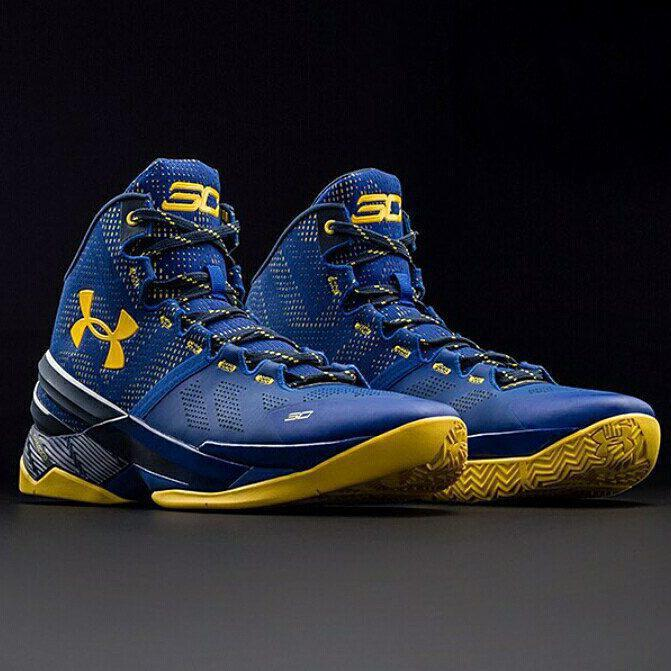

In [3]:
# Visualizing image 20 of the training set

sample_img = df.iloc[20].tolist()
print(sample_img)
num, image_path, tag = sample_img[0], sample_img[1], sample_img[0]
print(num)

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename=image_path)
#im = np.array(image).reshape((28, 28))
#plt.imshow(im, cmap='gray')

In [4]:
len(df)

7448

### Creating the torch Dataset.

First thing we need to do is create a dataset able to load our data. Since our metadata is stored in a csv file, our 
dataset should accept this file as a base source of what needs to be loaded.

Our dataset should also support augumentations and a "inference" mode wich disables them for predicting.


In [5]:
import PIL
from PIL import Image
import io
import requests
import torch


class OneClassImageClassificationDataset(Dataset):
    def __init__(self, annotations, image_transform):
        """
        annotations is a pandas dataframe
        
        """
        super().__init__()
        self.annotations = annotations
        self.image_transform = image_transform

    def __len__(self):
        """
        Return the length of the annotations dataframe
        """
        # your code here
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Using methods you wrote:
        1 - load image from disk for given index  (self.load_from_disk)
        2 - transform image (self.image_transform)
        3 - Load target (self.load_target)
        return Xi, yi
        """
        
        # YOUR CODE HERE
        Xi, yi = self.load_from_disk(index), self.load_target(index)
        Xi = self.image_transform(Xi)
        return Xi, yi

    def load_to_pil(self, uri):
        """
        Write a helper function that uses PIL.Image to load a file and convert to RGB and returns it
        
        """
        
        # YOUR CODE HERE
        image_pil = PIL.Image.open(uri).convert('RGB')
        
        return image_pil


    def load_from_disk(self, index):
        """
        Loads an image from disk given a index.
        It gets the path of an image with the corresponding index from the metadata 
        It passes the URI to the self.load_to_pil and returns a PIL.Image
        """
        
        # YOUR CODE HERE
        image_path = df.iloc[index]['image_path'] 
        return self.load_to_pil(image_path)

    def load_target(self, index):
        """
        This function should get the tag for a given index from the annotations dataframe
        You .iloc can become useful.    
        This methods should return, either a 0 or a 1.
        """
        
        # YOUR CODE HERE
        label = df.iloc[index]['tags']

        return label
    
    
class BaseSampler(Sampler):
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
    def __iter__(self):
        return iter(self._get_sample())
        
    def __len__(self):
        return self.n_samples
    
    def _get_sample(self):
        return np.random.choice(len(self.df), self.n_samples, replace=False)
        

def binary_classification_model():
    """
    Write a function that loads a resnet50 model from pretrainedmodels. 
    - freezes its layers
    - replaces the last_linear with the proper output number. As we did in previous example.
    - replace avgpool with adaptiv pooling.
    """
    model = resnet50()

    # model = YOUR CODE HERE
    for params in model.parameters():
        params.requires_grad = False
    
    model.avgpool = nn.AdaptiveAvgPool2d(1) # This will allow to use different input sizes
    
    model.last_linear = nn.Sequential(nn.Linear(model.last_linear.in_features, 1), nn.Sigmoid())
    
    return model



Let's check if the data gets loaded the length of the total set

In [6]:
ds = OneClassImageClassificationDataset(annotations=df, image_transform=None)
len(ds)

7448

In [7]:

# YOUR CODE HERE:
# SPLIT the dataframe into df_train, df_test (think about using sklearn.model_selection.train_test_split)

df_train, df_test = train_test_split(df, train_size=0.8)

df_train = df_train.reset_index()
df_test = df_test.reset_index()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 10
BATCH_SIZE = 16
IMAGE_SIZE = 32
THRESHOLD = 0.5 

image_transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define image_transform_test
image_transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define the criterion
criterion = nn.BCEWithLogitsLoss()

net = binary_classification_model()

optimizer = getattr(torch.optim, 'Adam')(net.parameters(), lr=0.001)

# initialize the BaseSampler with 1000 samples per epoch
bs = BaseSampler(df, 1000)

# YOUR CODE
# Instantiate the OneClassImageClassificationDatasets
train_ds = OneClassImageClassificationDataset(annotations=df_train, image_transform=image_transform_train)
test_ds = OneClassImageClassificationDataset(annotations=df_test, image_transform=image_transform_test)

#YOUR CODE
#Initialize your DataLoader (using datasets)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
#print(train_ds[0][0].unsqueeze(0).shape)
#net(train_ds[0][0].unsqueeze(0))

In [9]:
import numpy as np 
def evaluate_model(model, loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            
            pred = model(X).squeeze(1)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
        
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba > THRESHOLD #.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(acc))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
        

# Training Loop

In [10]:

metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []
net.to(DEVICE)

for epoch in range(N_EPOCHS):
    for X, y in train_dl:
        X = X.to(DEVICE)
        y = y.to(DEVICE).float()
        y = y
        optimizer.zero_grad()
        ypred=net(X).squeeze(1)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    testll, testacc = evaluate_model(net, test_dl)
    trainll, trainacc = evaluate_model(net, train_dl)
    print("test: {} {}".format(testll, testacc))
    print("train: {} {}".format(trainll, trainacc))
    metrics.append([trainll, testll, trainacc, testacc])

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


test: 0.6467916426442614 0.5416107382550336
train: 0.6483951698477215 0.5436388049681101


/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


KeyboardInterrupt: 

In [ ]:
len(df)